In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches

import os
import sys

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy import stats


MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project') # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from utils.measures import calculate_nrmse, calculate_spearman, intra_dissimilarity, inter_dissimilarity

In [2]:
sns.set_style('whitegrid')

In [3]:
%cd /storage/zkarwowska/predicting-microbiome-in-time/linear-models/

/storage/zkarwowska/predicting-microbiome-in-time/linear-models


### BENCHMARK MODELS

In [4]:
METADATA_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/qiita_550/raw_data/550_metadata.txt'
metadata = pd.read_csv(METADATA_FILE, sep = '\t')
metadata = metadata[(metadata['body_product'] == 'UBERON:feces') & \
                    (metadata['sex'] == 'male') & \
                    (metadata['mislabeled']==False)].sort_values(by = 'days_since_experiment_start')

dates = pd.date_range(start=metadata['collection_timestamp'].min(), end=metadata['collection_timestamp'].max(), freq='D')

In [5]:
#TRUE
true_test = pd.read_csv('linear-forest/results/otu_prediction/ridge_true_test_lag2.csv', index_col=[0]).reset_index(drop=True)
true_test.columns = [i.split('_')[0] for i in true_test.columns]

#LINEAR FOREST ENET
enet_lin_forest = pd.read_csv('linear-forest/enet_pred_test_lag5.csv', index_col=[0])

#LINEAR FOREST RIDGE
ridge_lin_forest = pd.read_csv('linear-forest/results/otu_prediction/ridge_pred_test_lag5.csv', index_col=[0])

#RIDGE REGRESSION
ridge_regression = pd.read_csv('ridge-regression/results/ridge_pred_test_lag5.csv', index_col=[0])

#KERNEL RIDGE REGRESSION
kernel_regression = pd.read_csv('kernel-ridge-regression/results/kernel-ridge_pred_test_lag5.csv', index_col=[0])

#RANDOM FOREST REGRESSOR
random_forest = pd.read_csv('random-forest/male_prediction_test.csv', index_col=[0])

### OTU TRAJECTORY PLOTS

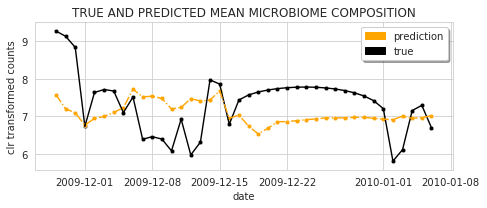

In [72]:
true_mean = pd.DataFrame(true_test.T.mean(), columns = ['mean'])
pred_mean = pd.DataFrame(enet_lin_forest.T.mean(), columns = ['mean'])

idx = dates[-40:]

plt.figure(figsize=(7, 3))
sns.lineplot(x = idx, y=true_mean['mean'].values, color='black', linewidth=1.4)
sns.scatterplot(x = idx, y=true_mean['mean'].values, color='black', s=20)

sns.lineplot(x = idx, y=pred_mean['mean'].values, color='orange', linewidth=1.4, linestyle='-.')
sns.scatterplot(x = idx, y=pred_mean['mean'].values, color='orange', s=20)

plt.title('TRUE AND PREDICTED MEAN MICROBIOME COMPOSITION')
plt.ylabel('clr transformed counts')
plt.xlabel('date')

o_patch = mpatches.Patch(color='orange', label='prediction')
b_patch = mpatches.Patch(color='black', label='true')
plt.legend(handles=[o_patch, b_patch], shadow=True)

plt.tight_layout()
plt.savefig('linear-forest/eccb_plots/mean_prediction.png')

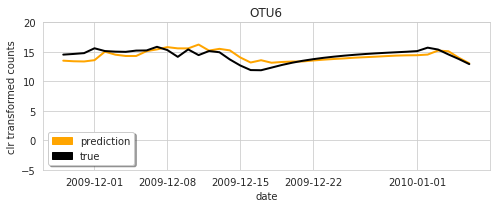

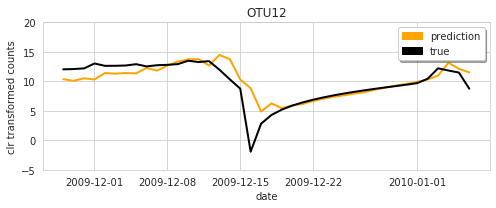

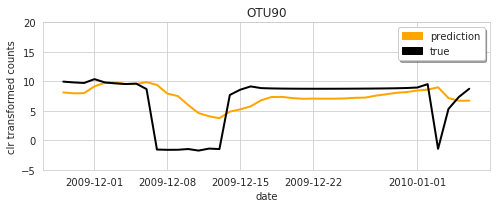

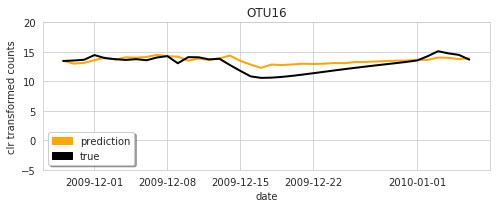

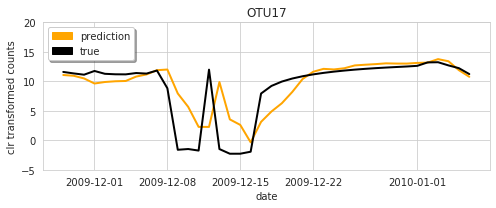

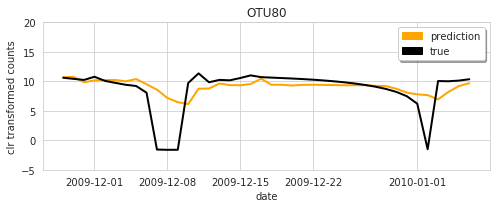

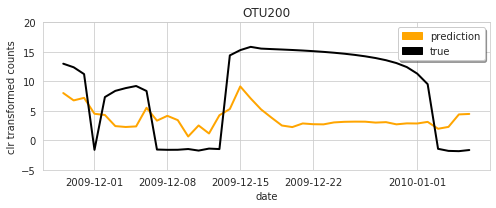

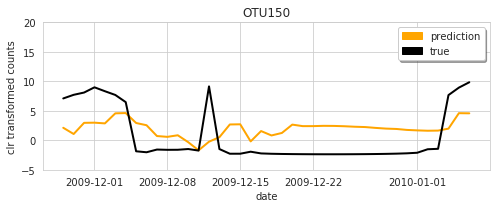

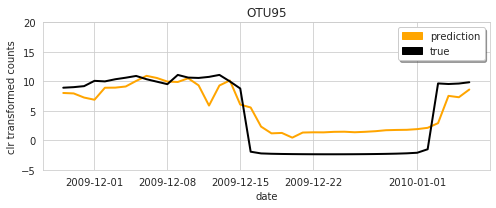

In [74]:
idx = dates[-40:]

for i in [6, 12, 90, 16, 17, 80, 200, 150, 95]: 
    
    plt.figure(figsize=(7, 3))
    sns.lineplot(y=enet_lin_forest.iloc[:, i].values, x =idx, linewidth=2, color='orange')
    #sns.scatterplot(y=enet_lin_forest.iloc[:, i].values, x = idx, color='orange')
    
    sns.lineplot(y=true_test.iloc[:, i].values, x = idx, linewidth=2, color='k')
    #sns.scatterplot(y=true_test.iloc[:, i].values, x = idx, color='k', s=50)
    
    plt.ylim(-5, 20)
    
    plt.title('OTU{}'.format(i))
    plt.ylabel('clr transformed counts')
    plt.xlabel('date')
    
    o_patch = mpatches.Patch(color='orange', label='prediction')
    b_patch = mpatches.Patch(color='black', label='true')
    plt.legend(handles=[o_patch, b_patch], shadow=True)
    
    plt.tight_layout()
    plt.savefig('linear-forest/eccb_plots/predictions/{}_pred.png'.format(i))
    #plt.show()

### PEARSON CORRELATION COEFFICIENT

In [7]:
def calculate_pearson(true, pred):
    
    PEARSON_RHO = []
    for col in true_test.columns:
        rho = stats.pearsonr(true[col], pred[col])[0]
        PEARSON_RHO.append(rho)
    return pd.DataFrame(PEARSON_RHO, columns = ['pearson_rho'])

In [10]:
enet_lin_forest_pearson = calculate_pearson(enet_lin_forest, true_test)
ridge_regression_pearson = calculate_pearson(ridge_regression, true_test)
random_forest_pearson = calculate_pearson(random_forest, true_test)


enet_lin_forest_pearson['MODEL'] = 'RERF'
ridge_regression_pearson['MODEL'] = 'PENALIZED REGRESSION'
random_forest_pearson['MODEL'] = 'RANDOM FOREST'


PEARSON_RHO_DF = enet_lin_forest_pearson.append(ridge_regression_pearson).append(random_forest_pearson)

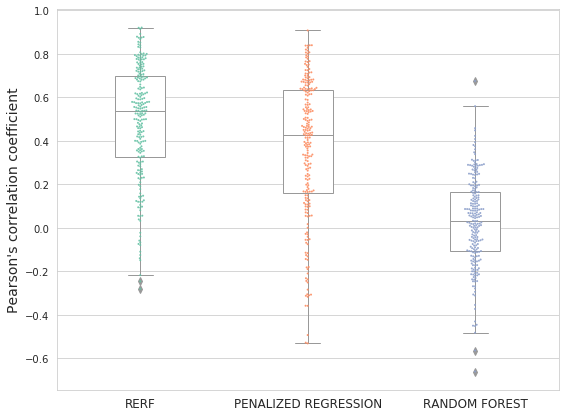

In [60]:
plt.figure(figsize=(9, 7))
sns.boxplot(data=PEARSON_RHO_DF,
            x = 'MODEL', 
            y='pearson_rho',
            width=.3, 
            linewidth=1,
           color='white')

sns.swarmplot(data=PEARSON_RHO_DF,
              x = 'MODEL', 
              y='pearson_rho', s=2, 
              alpha=.9,
              palette = 'Set2')
plt.ylabel("Pearson's correlation coefficient", size=14)
plt.xlabel('')
plt.xticks(size=12)

plt.savefig('linear-forest/eccb_plots/pearson.png')

### RANDOM FOREST

In [15]:
enet_lin_forest_rho = calculate_spearman(enet_lin_forest, true_test, 'spearman_rho')
ridge_regression_rho = calculate_spearman(ridge_regression, true_test, 'spearman_rho')
random_forest_rho = calculate_spearman(random_forest, true_test, 'spearman_rho')


enet_lin_forest_rho['MODEL'] = 'RERF'
ridge_regression_rho['MODEL'] = 'PENALIZED REGRESSION'
random_forest_rho['MODEL'] = 'RANDOM FOREST'


RHO_DF = enet_lin_forest_rho.append(ridge_regression_rho).append(random_forest_rho)

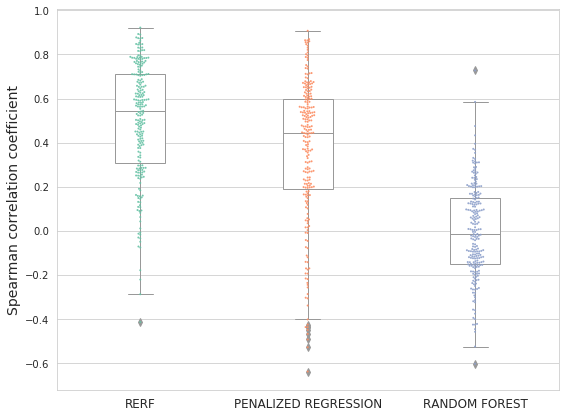

In [61]:
plt.figure(figsize=(9, 7))
sns.boxplot(data=RHO_DF,
            x = 'MODEL', 
            y='spearman_rho',
            width=.3, 
            linewidth=1,
           color='white')

sns.swarmplot(data=RHO_DF,
              x = 'MODEL', 
              y='spearman_rho', s=2, 
              alpha=.9,
              palette = 'Set2')
plt.ylabel("Spearman correlation coefficient", size=14)
plt.xlabel('')
plt.xticks(size=12)


plt.savefig('linear-forest/eccb_plots/spearman.png')

### BRAY CURTIS DISTANCE

In [17]:
enet_lin_forest_bc = inter_dissimilarity(enet_lin_forest, true_test, 'bray_curtis')
ridge_regression_bc = inter_dissimilarity(ridge_regression, true_test, 'bray_curtis')
rf_bc = inter_dissimilarity(random_forest, true_test, 'bray_curtis')


enet_lin_forest_bc['MODEL'] = 'RERF'
ridge_regression_bc['MODEL'] = 'PENALIZED REGRESSION'
rf_bc['MODEL'] = 'RANDOM FOREST'

BC_DF = enet_lin_forest_bc.append(ridge_regression_bc).append(rf_bc)

In [37]:
pal = sns.color_palette('Set2')
print(pal.as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


In [38]:
model_dict = {'RERF': '#66c2a5', 'PENALIZED REGRESSION':'#fc8d62', 'RANDOM FOREST':'#8da0cb'}

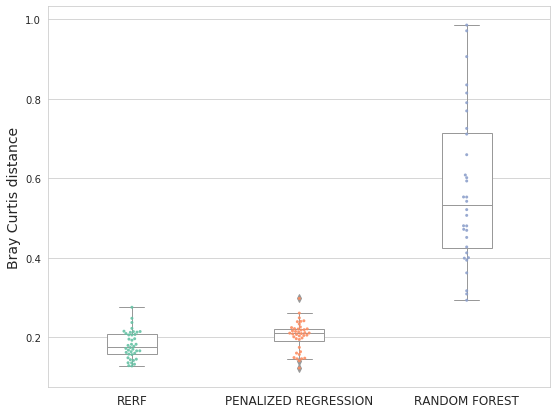

In [62]:
plt.figure(figsize=(9, 7))
sns.boxplot(data=BC_DF[BC_DF.bray_curtis <1],
            x = 'MODEL', 
            y='bray_curtis',
            width=.3, 
            linewidth=1,
           color='white')

sns.swarmplot(data=BC_DF[BC_DF.bray_curtis <1],
              x = 'MODEL', 
              y='bray_curtis', s=3, 
              alpha=.9,
              palette = model_dict)
plt.ylabel("Bray Curtis distance", size=14)
plt.xlabel('')
plt.xticks(size=12)

plt.savefig('linear-forest/eccb_plots/bc.png')

### PROCRUSTES

In [25]:
lin_forest_procrustes = intra_dissimilarity(true_test, enet_lin_forest)[4]
ridge_procrustes = intra_dissimilarity(true_test, ridge_regression)[4]
rf_procrustes = intra_dissimilarity(random_forest, ridge_regression)[4]

/home/MCB/zkarwowska/anaconda3/envs/basic_env/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -64.49200018378636 and the largest is 87.05288333441784.
  RuntimeWarning


In [26]:
PROCRUSTES_DF = pd.DataFrame(list(zip(['RERF', 'PENALIZED REGRESSION', 'RANDOM FOREST'], [lin_forest_procrustes, ridge_procrustes, rf_procrustes])), columns = ['MODEL', 'PROCRUSTES'])

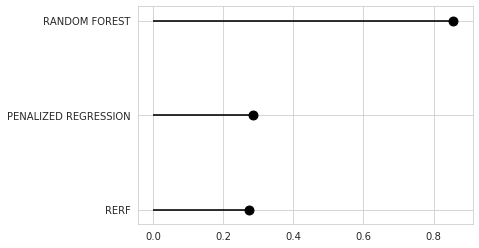

In [27]:
my_range=range(0,len(PROCRUSTES_DF['MODEL']))
plt.hlines(y=PROCRUSTES_DF['MODEL'], xmin=0, xmax=PROCRUSTES_DF['PROCRUSTES'], color='k',linewidth=2, alpha =0.8)
plt.scatter(PROCRUSTES_DF['PROCRUSTES'], my_range, color='k', s=80, alpha=1)

custom_lines = [plt.Line2D([0], [0], color="#ffa600", lw=4),
                plt.Line2D([0], [0], color="#f95d6a", lw=4),
                plt.Line2D([0], [0], color="#a05195", lw=4)]


### PCA

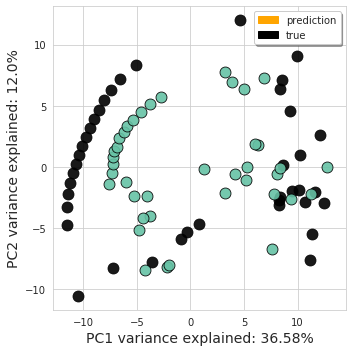

In [63]:
annot = true_test.index

true_pca = PCA()

true_scaler = StandardScaler()
pred_scaler = StandardScaler()

true_X = true_scaler.fit_transform(true_test)
pred_X = pred_scaler.fit_transform(enet_lin_forest)

true_pca_comp = true_pca.fit_transform(true_X)
pred_pca_comp = true_pca.transform(pred_X)

plt.figure(figsize=(5, 5))
sns.scatterplot(x = true_pca_comp[:, 0], y=true_pca_comp[:, 1], s=120, alpha=.9, edgecolor='k', color='k')
sns.scatterplot(x = pred_pca_comp[:, 0], y=pred_pca_comp[:, 1], color='#66c2a5', s=120, alpha=.9, edgecolor='k')
plt.tight_layout()

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlabel("PC1 variance explained: {}%".format(np.round(true_pca.explained_variance_ratio_[0]*100, 2)), fontsize = 14)
plt.ylabel("PC2 variance explained: {}%".format(np.round(true_pca.explained_variance_ratio_[1]*100), 2), fontsize = 14)

red_patch = mpatches.Patch(color='orange', label='prediction')
balck_patch = mpatches.Patch(color='black', label='true')
plt.legend(handles=[red_patch, balck_patch], shadow=True)

plt.tight_layout()
plt.savefig('linear-forest/eccb_plots/PCA_lin_forest.png')

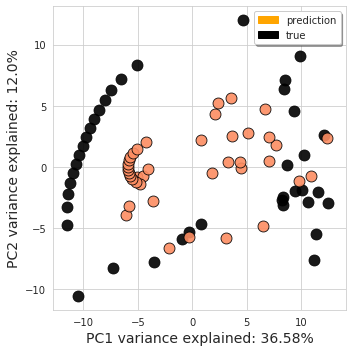

In [64]:
annot = true_test.index

true_pca = PCA()

true_scaler = StandardScaler()
pred_scaler = StandardScaler()

true_X = true_scaler.fit_transform(true_test)
pred_X = pred_scaler.fit_transform(ridge_regression)

true_pca_comp = true_pca.fit_transform(true_X)
pred_pca_comp = true_pca.transform(pred_X)

plt.figure(figsize=(5, 5))
sns.scatterplot(x = true_pca_comp[:, 0], y=true_pca_comp[:, 1], s=120, alpha=.9, edgecolor='k', color='k')
sns.scatterplot(x = pred_pca_comp[:, 0], y=pred_pca_comp[:, 1], color='#fc8d62', s=120, alpha=.9, edgecolor='k')
plt.tight_layout()

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlabel("PC1 variance explained: {}%".format(np.round(true_pca.explained_variance_ratio_[0]*100, 2)), fontsize = 14)
plt.ylabel("PC2 variance explained: {}%".format(np.round(true_pca.explained_variance_ratio_[1]*100), 2), fontsize = 14)

red_patch = mpatches.Patch(color='orange', label='prediction')
balck_patch = mpatches.Patch(color='black', label='true')
plt.legend(handles=[red_patch, balck_patch], shadow=True)

plt.tight_layout()
plt.savefig('linear-forest/eccb_plots/PCA_ridge_regression.png')

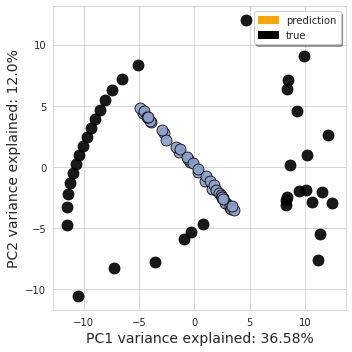

In [65]:
annot = true_test.index

true_pca = PCA()

true_scaler = StandardScaler()
pred_scaler = StandardScaler()

true_X = true_scaler.fit_transform(true_test)
pred_X = pred_scaler.fit_transform(random_forest)

true_pca_comp = true_pca.fit_transform(true_X)
pred_pca_comp = true_pca.transform(pred_X)

plt.figure(figsize=(5, 5))
sns.scatterplot(x = true_pca_comp[:, 0], y=true_pca_comp[:, 1], s=120, alpha=.9, edgecolor='k', color='k')
sns.scatterplot(x = pred_pca_comp[:, 0], y=pred_pca_comp[:, 1], color='#8da0cb', s=120, alpha=.9, edgecolor='k')
plt.tight_layout()

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlabel("PC1 variance explained: {}%".format(np.round(true_pca.explained_variance_ratio_[0]*100, 2)), fontsize = 14)
plt.ylabel("PC2 variance explained: {}%".format(np.round(true_pca.explained_variance_ratio_[1]*100), 2), fontsize = 14)

red_patch = mpatches.Patch(color='orange', label='prediction')
balck_patch = mpatches.Patch(color='black', label='true')
plt.legend(handles=[red_patch, balck_patch], shadow=True)

plt.tight_layout()
plt.savefig('linear-forest/eccb_plots/PCA_random_forest.png')